In [1]:
import pandas as pd
from prophet import Prophet

train_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\train_data.csv")
test_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\test_data.csv")

prophet_train = train_df[["date", "solar_radiation_langley"]].copy()
prophet_train.columns = ["ds", "y"]

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

# For training data
train_future = prophet_train[["ds"]]
train_forecast = model.predict(train_future)

train_df["trend"] = train_forecast["trend"].values
train_df["seasonal"] = train_forecast["yearly"].values + train_forecast["daily"].values
train_df["residual"] = train_df["solar_radiation_langley"] - train_df["trend"] - train_df["seasonal"]

# For testing data
prophet_test = test_df[["date"]].copy()
prophet_test.columns = ["ds"]
test_forecast = model.predict(prophet_test)

test_df["trend"] = test_forecast["trend"].values
test_df["seasonal"] = test_forecast["yearly"].values + test_forecast["daily"].values
test_df["residual"] = test_df["solar_radiation_langley"] - test_df["trend"] - test_df["seasonal"]


input_features = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

X_train = train_df[input_features].values
y_train = train_df["solar_radiation_langley"].values

X_test = test_df[input_features].values
y_test = test_df["solar_radiation_langley"].values

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:26:39 - cmdstanpy - INFO - Chain [1] start processing
09:26:39 - cmdstanpy - INFO - Chain [1] done processing


In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ---- Hyperparameters ----
theta_dim = 6
num_blocks = 3
epochs = 70
lr = 1e-3
batch_size = 16

# ==== Fully connected projection for each N-HiTS block ====
class NHITSBlock(nn.Module):
    def __init__(self, input_dim, theta_dim):
        super().__init__()
        self.backcast_fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, theta_dim),
            nn.ReLU(),
            nn.Linear(theta_dim, input_dim)
        )
        self.forecast_fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, theta_dim),
            nn.ReLU(),
            nn.Linear(theta_dim, 1)
        )

    def forward(self, x):
        backcast = self.backcast_fc(x)
        forecast = self.forecast_fc(x)
        return backcast, forecast

# ==== NHITS model ====
class NHITS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            NHITSBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])

    def forward(self, x):
        forecast_total = 0
        for block in self.blocks:
            backcast, forecast = block(x)
            x = x - backcast  # residual learning
            forecast_total += forecast
        return forecast_total

# ==== Prepare Tensors ====
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# ==== DataLoaders ====
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# ==== Initialize model and training components ====
model = NHITS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

d:\Python\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [3]:
# ==== Training Loop ====
train_losses = []
test_losses = []
best_val_loss = float('inf')
best_model_path = r"D:\Projects\quantum forecasting\models\best_Nmodel_nhits1.pth"

print("🚀 Starting training...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_preds = model(test_x)
        test_loss = criterion(test_preds, test_y)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

    if test_loss.item() < best_val_loss:
        best_val_loss = test_loss.item()
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved new best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

print("\n🎯 Training complete.")

🚀 Starting training...

Epoch 1/70 - Train Loss: 0.1489 - Test Loss: 0.0387
✅ Saved new best model at epoch 1 with val loss 0.0387
Epoch 2/70 - Train Loss: 0.0447 - Test Loss: 0.0425
Epoch 3/70 - Train Loss: 0.0422 - Test Loss: 0.0492
Epoch 4/70 - Train Loss: 0.0417 - Test Loss: 0.0606
Epoch 5/70 - Train Loss: 0.0427 - Test Loss: 0.0353
✅ Saved new best model at epoch 5 with val loss 0.0353
Epoch 6/70 - Train Loss: 0.0353 - Test Loss: 0.0393
Epoch 7/70 - Train Loss: 0.0373 - Test Loss: 0.0343
✅ Saved new best model at epoch 7 with val loss 0.0343
Epoch 8/70 - Train Loss: 0.0364 - Test Loss: 0.0370
Epoch 9/70 - Train Loss: 0.0342 - Test Loss: 0.0301
✅ Saved new best model at epoch 9 with val loss 0.0301
Epoch 10/70 - Train Loss: 0.0312 - Test Loss: 0.0305
Epoch 11/70 - Train Loss: 0.0336 - Test Loss: 0.0301
✅ Saved new best model at epoch 11 with val loss 0.0301
Epoch 12/70 - Train Loss: 0.0305 - Test Loss: 0.0288
✅ Saved new best model at epoch 12 with val loss 0.0288
Epoch 13/70 - Tra

In [3]:
model = NHITS(input_dim=X_test.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
best_model_path = r"D:\Projects\quantum forecasting\models\best_Nmodel_nhits1.pth"
model.load_state_dict(torch.load(best_model_path))

with torch.no_grad():
    y_pred = model(X_test_t)
    test_loss = criterion(y_pred, y_test_t)
    print(f"✅ Loaded best model - Test Loss: {test_loss.item():.4f}")


✅ Loaded best model - Test Loss: 0.0190


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_13776\118206919.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure predictions and targets are NumPy arrays
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

# Compute accuracy metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.1065
Mean Squared Error (MSE): 0.0190
Root Mean Squared Error (RMSE): 0.1379
R² Score: 0.9806


In [6]:
from torchinfo import summary

# Assuming batch size 32
summary(model, input_size=(16, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
NHITS                                    [16, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─NHITSBlock: 2-1                   [16, 9]                   --
│    │    └─Sequential: 3-1              [16, 9]                   4,165
│    │    └─Sequential: 3-2              [16, 1]                   4,109
│    └─NHITSBlock: 2-2                   [16, 9]                   --
│    │    └─Sequential: 3-3              [16, 9]                   4,165
│    │    └─Sequential: 3-4              [16, 1]                   4,109
│    └─NHITSBlock: 2-3                   [16, 9]                   --
│    │    └─Sequential: 3-5              [16, 9]                   4,165
│    │    └─Sequential: 3-6              [16, 1]                   4,109
Total params: 24,822
Trainable params: 24,822
Non-trainable params: 0
Total mult-adds (M): 0.40
Input size (MB): 0.00
Forward/backward pa

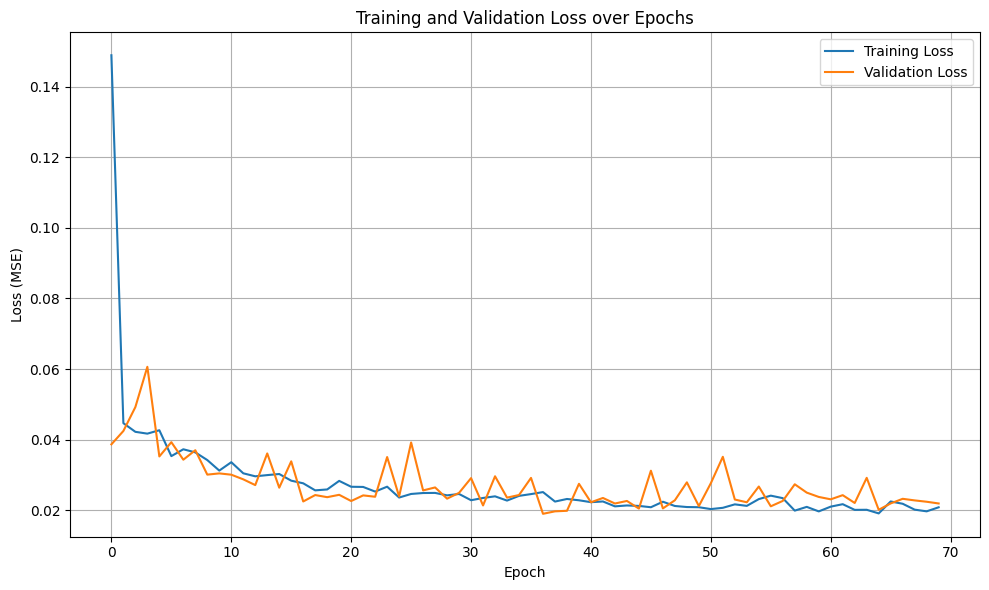

In [7]:
import matplotlib.pyplot as plt

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\loss_plot_N.png")
plt.show()

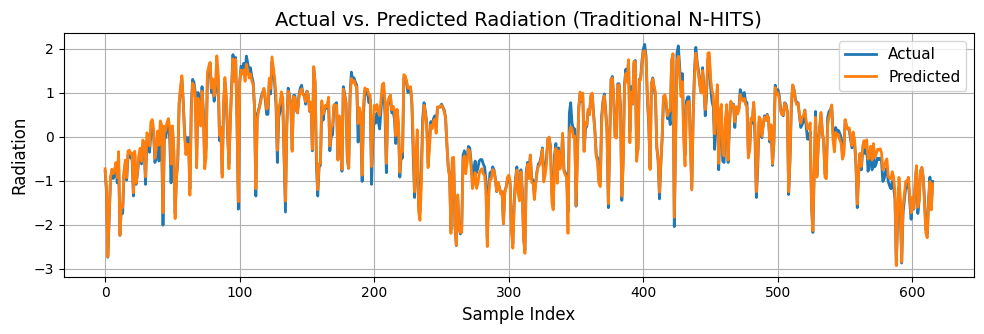

In [5]:
import matplotlib.pyplot as plt

# Set global font styles for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# Create plot
plt.figure(figsize=(10, 3.5))  # Ideal for one-column width (approx 3.5–3.7 in in journals)
plt.plot(y_test_np, label='Actual', linewidth=2)
plt.plot(y_pred_np, label='Predicted', linewidth=2)

plt.title("Actual vs. Predicted Radiation (Traditional N-HITS)")
plt.xlabel("Sample Index")
plt.ylabel("Radiation")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NHITS\actual_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()


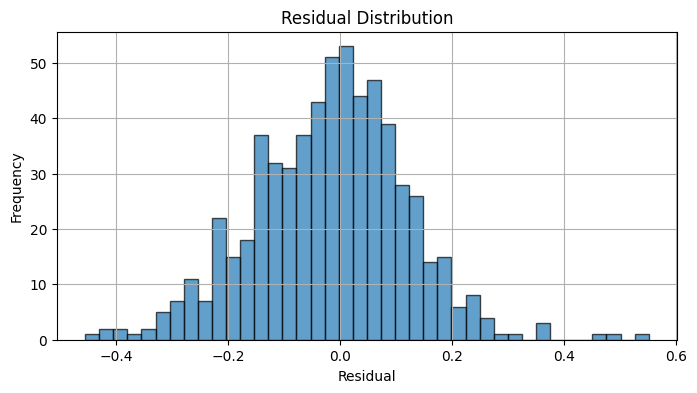

In [9]:
residuals = y_test_np - y_pred_np
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=40, alpha=0.7, edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\residual_distribution_N.png")
plt.show()

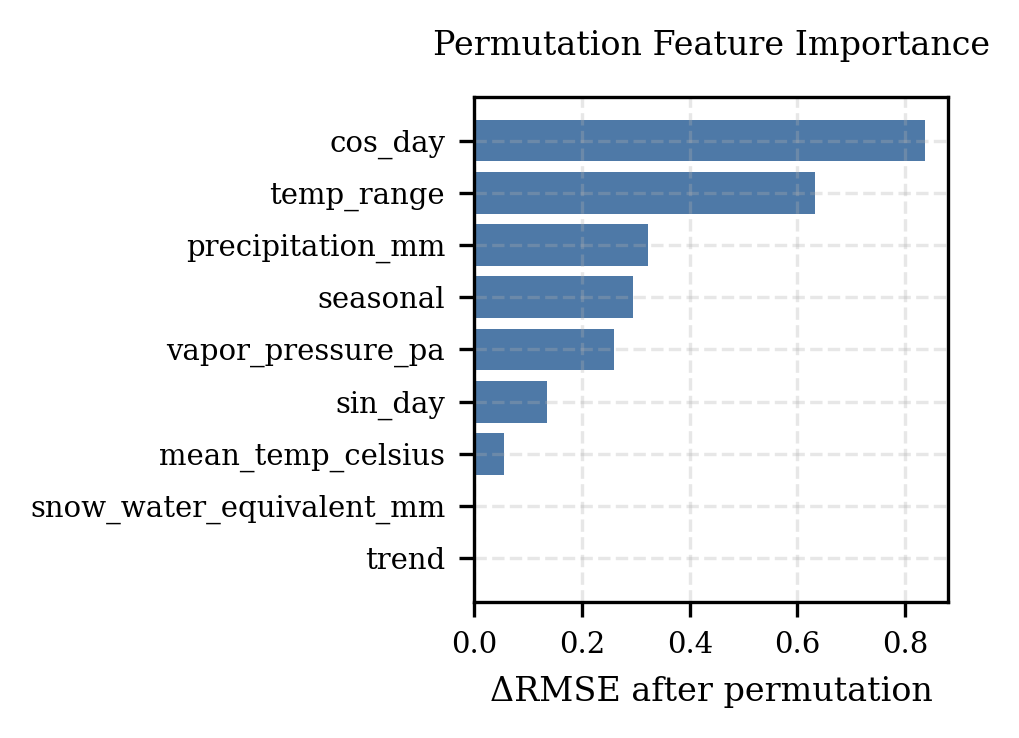

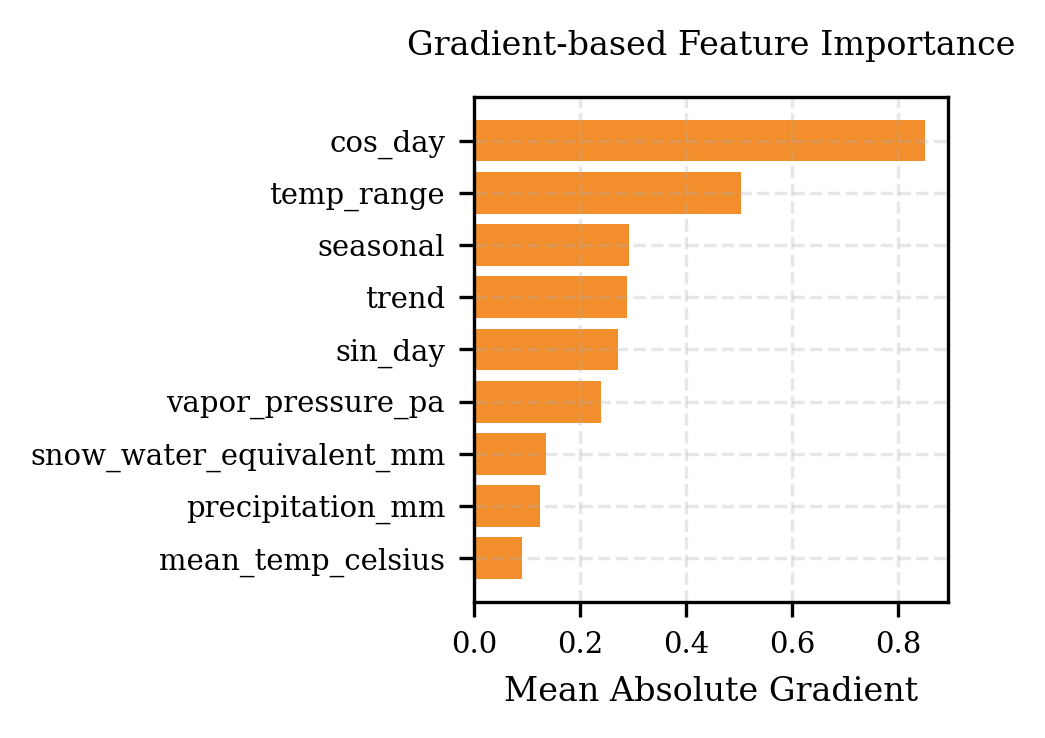

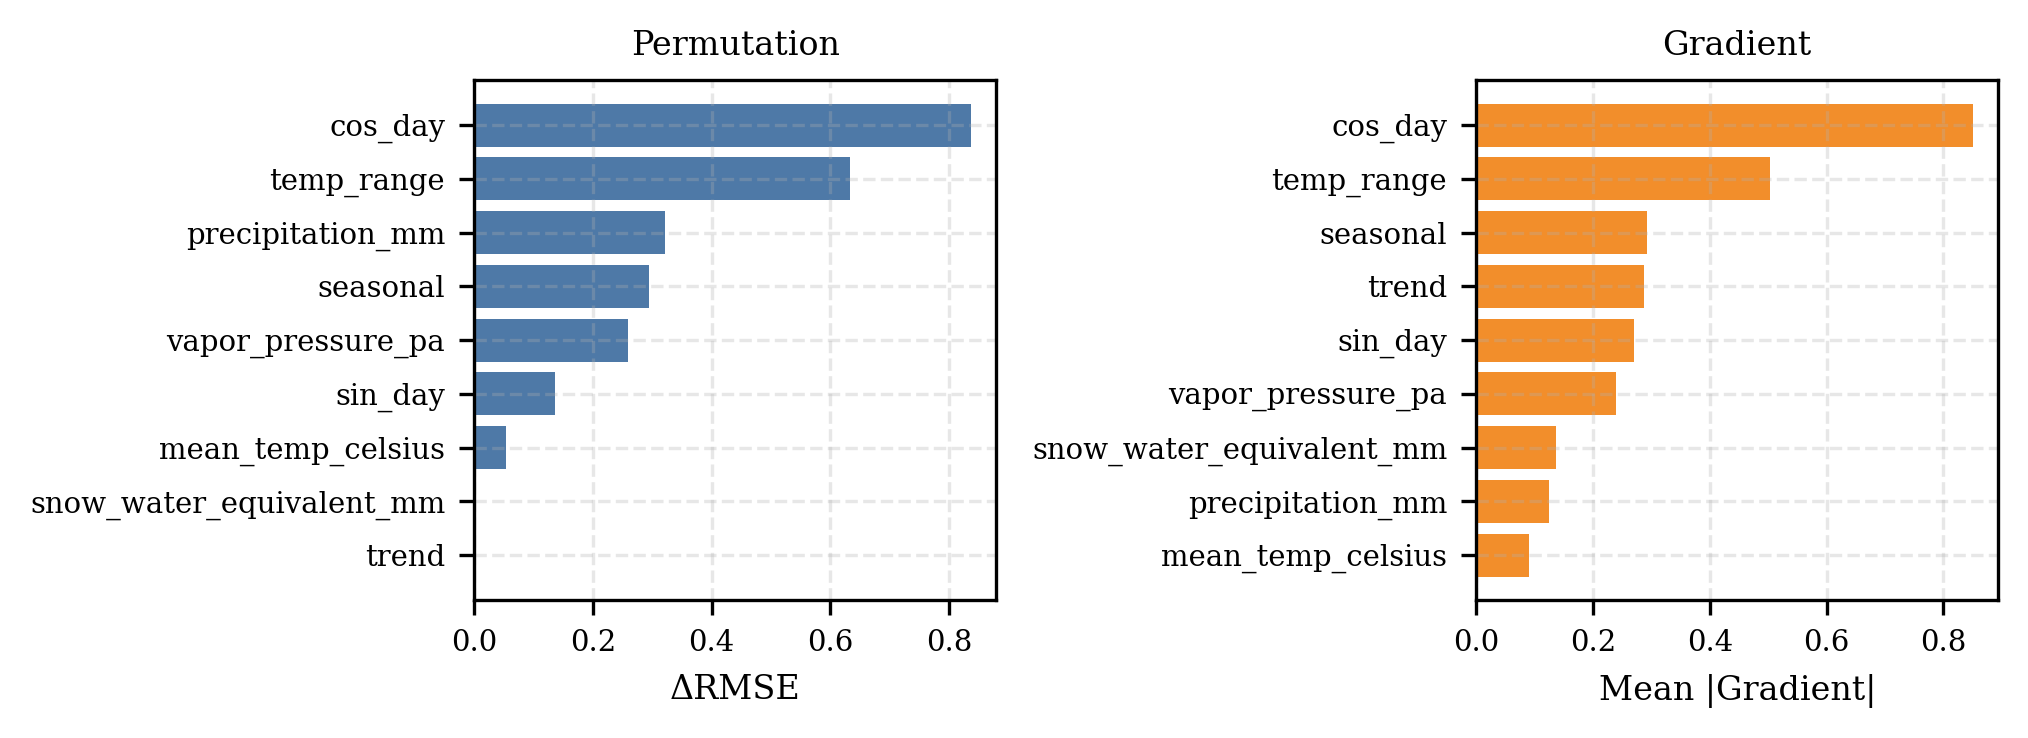

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from sklearn.metrics import mean_squared_error

# ---------- PREPARE ----------
model.eval()

# Clone data for safety
X_test_perm = X_test_t.clone()
y_test_true = y_test_t.clone()
base_preds = model(X_test_perm).detach().numpy().flatten()
base_rmse = np.sqrt(mean_squared_error(y_test_true.numpy(), base_preds))

# ---------- PERMUTATION IMPORTANCE ----------
perm_importances = []
feature_names = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

for i in range(X_test_perm.shape[1]):
    X_permuted = X_test_perm.clone()
    idx = torch.randperm(X_test_perm.size(0))
    X_permuted[:, i] = X_permuted[idx, i]  # Shuffle one column
    perm_preds = model(X_permuted).detach().numpy().flatten()
    perm_rmse = np.sqrt(mean_squared_error(y_test_true.numpy(), perm_preds))
    importance = perm_rmse - base_rmse
    perm_importances.append(importance)

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (RMSE Increase)": perm_importances
}).sort_values(by="Importance (RMSE Increase)", ascending=True)

# ---------- GRADIENT-BASED IMPORTANCE ----------
X_test_t.requires_grad = True
grad_importances = torch.zeros(X_test_t.shape[1])

for i in range(X_test_t.shape[0]):
    model.zero_grad()
    output = model(X_test_t[i:i+1])
    output.backward(torch.ones_like(output))
    grad_importances += X_test_t.grad[i].abs().detach()

grad_importances /= X_test_t.shape[0]
grad_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Gradient Importance": grad_importances.numpy()
}).sort_values(by="Gradient Importance", ascending=True)

# ---------- IEEE/Elsevier PLOTTING ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.figsize": (3.3, 2.5),
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# --- Permutation Plot ---
plt.figure()
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
plt.xlabel("ΔRMSE after permutation")
plt.title("Permutation Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NHITS\permutation_importance.png")
plt.show()

# --- Gradient Plot ---
plt.figure()
plt.barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
plt.xlabel("Mean Absolute Gradient")
plt.title("Gradient-based Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NHITS\gradient_importance.png")
plt.show()

# --- Combined Plot (Optional) ---
fig, ax = plt.subplots(1, 2, figsize=(6.8, 2.5))
ax[0].barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
ax[0].set_title("Permutation", fontsize=8)
ax[0].set_xlabel("ΔRMSE", fontsize=8)

ax[1].barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
ax[1].set_title("Gradient", fontsize=8)
ax[1].set_xlabel("Mean |Gradient|", fontsize=8)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=7)
    a.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NHITS\feature_importance_combined.png")
plt.show()
